# Link Prediction

GPU acceleration dengan CUDA

In [2]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [9]:
!pip install igraph

In [10]:
!pip install networkit

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import pickle
import random
import igraph as ig
import networkit as nk

from itertools import combinations
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Dataset Preparation

In [2]:
pickle_file_path = 'dataset/amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'rb') as f:
    G = pickle.load(f)

print(G)

DiGraph with 259102 nodes and 1207337 edges


### Features

#### Node Features

In [3]:

print(f"Total Nodes: {G.number_of_nodes()}")


for node, data in list(G.nodes(data=True))[:5]:
    print(f"Node: {node}, Data: {data}")

print()
sample_node = next(iter(G.nodes(data=True)))[1]
print("Node features:", list(sample_node.keys()))

Total Nodes: 259102
Node: 1, Data: {'title': 'Patterns of Preaching: A Sermon Sampler', 'group': 'Book', 'salesrank': 396585.0, 'review_cnt': 2, 'downloads': 2, 'rating': 5.0, 'in_degree': 0, 'out_degree': 4, 'pagerank_centrality': 6.210153588242165e-07, 'betweenness_centrality': 0.0, 'harmonic_closeness_centrality': 0.1442557706580312, 'degree_centrality': 1.5437995221940477e-05, 'community': 10}
Node: 2, Data: {'title': 'Candlemas: Feast of Flames', 'group': 'Book', 'salesrank': 168596.0, 'review_cnt': 12, 'downloads': 12, 'rating': 4.5, 'in_degree': 1, 'out_degree': 4, 'pagerank_centrality': 7.560926314778459e-07, 'betweenness_centrality': 31563.672353370643, 'harmonic_closeness_centrality': 0.1444868764333364, 'degree_centrality': 1.92974940274256e-05, 'community': 10}
Node: 4, Data: {'title': 'Life Application Bible Commentary: 1 and 2 Timothy and Titus', 'group': 'Book', 'salesrank': 631289.0, 'review_cnt': 1, 'downloads': 1, 'rating': 4.0, 'in_degree': 24, 'out_degree': 5, 'page

Fitur-fitur dari node dalam graph ini meliputi:  

*   **`title`**:  
    *   **Tipe Data**: String (Teks)  
    *   **Deskripsi**: Nama atau judul produk. Fitur ini memberikan deskripsi tekstual tentang produk yang dimaksud.  
    *   **Contoh**: "Patterns of Preaching: A Sermon Sampler", "Candlemas: Feast of Flames", dll.  

*   **`group`**:  
    *   **Tipe Data**: String (Kategorikal)  
    *   **Deskripsi**: Kategori atau grup tempat produk tersebut berada. Fitur ini membantu dalam memahami jenis produk (misalnya, Buku, Musik, DVD, dll.).  
    *   **Contoh**: "Book"  

*   **`salesrank`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Peringkat penjualan produk di Amazon. Semakin rendah nilai `salesrank`, semakin tinggi tingkat penjualan dan popularitasnya. Fitur ini sering digunakan untuk mengukur seberapa baik suatu produk terjual di Amazon.  
    *   **Contoh**: `396585.0`, `168596.0`, `1270652.0`, dll.  

*   **`review_cnt`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah ulasan pelanggan yang diterima oleh produk. Nilai `review_cnt` yang lebih tinggi bisa menunjukkan tingkat visibilitas produk yang lebih besar, popularitas yang lebih tinggi, atau keterlibatan pelanggan yang lebih banyak.  
    *   **Contoh**: `2`, `12`, `1`, `1`, `0`, dll.  

*   **`downloads`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah unduhan yang terkait dengan produk. Makna pastinya dapat bervariasi tergantung pada sumber dataset. Bisa saja mewakili unduhan produk digital atau metrik keterlibatan lainnya. Dalam konteks produk "Book" pada contoh ini, bisa merujuk pada unduhan sampel buku atau bentuk keterlibatan lain yang relevan dengan dataset.  
    *   **Contoh**: `2`, `12`, `1`, `1`, `0`, dll.  

*   **`rating`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Rata-rata rating pelanggan terhadap produk, biasanya dalam skala 0 hingga 5 (atau sistem serupa). Fitur ini mencerminkan tingkat kepuasan pelanggan serta persepsi kualitas produk secara keseluruhan.  
    *   **Contoh**: `5.0`, `4.5`, `5.0`, `4.0`, `0.0`, dll.   

*   **`in_degree`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah edge (sisi) yang masuk ke node ini. Menunjukkan seberapa banyak produk lain yang terhubung ke produk ini dalam graph. Dalam konteks dataset ini, bisa menunjukkan seberapa sering produk ini direferensikan oleh produk lain.  
    *   **Contoh**: `0`, `1`, `24`, `53`, `21`, dll.  

*   **`out_degree`**:  
    *   **Tipe Data**: Integer  
    *   **Deskripsi**: Jumlah edge (sisi) yang keluar dari node ini. Menunjukkan seberapa banyak produk lain yang direferensikan oleh produk ini.  
    *   **Contoh**: `4`, `4`, `5`, `5`, `5`, dll.  

*   **`pagerank_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Skor PageRank node dalam graph. Metrik ini mengukur kepentingan sebuah node berdasarkan jumlah dan kualitas tautan yang mengarah ke node tersebut. Semakin tinggi nilainya, semakin berpengaruh node tersebut dalam jaringan.  
    *   **Contoh**: `6.21e-07`, `7.56e-07`, `1.34e-05`, dll.  

*   **`betweenness_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Mengukur seberapa sering sebuah node menjadi perantara dalam jalur terpendek antara dua node lainnya. Node dengan betweenness centrality tinggi berperan sebagai "jembatan" yang menghubungkan berbagai bagian dalam graph.  
    *   **Contoh**: `0.0`, `31563.67`, `6528478.27`, `15442396.47`, dll.  

*   **`harmonic_closeness_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Versi alternatif dari closeness centrality yang menghitung seberapa dekat suatu node dengan node lain berdasarkan jarak harmonik. Makin tinggi nilainya, makin dekat node tersebut ke banyak node lain dalam graph.  
    *   **Contoh**: `0.1442`, `0.1444`, `0.1558`, `0.1658`, dll.  

*   **`degree_centrality`**:  
    *   **Tipe Data**: Float  
    *   **Deskripsi**: Mengukur proporsi node lain yang terhubung dengan node ini dalam graph. Degree centrality dihitung sebagai jumlah total koneksi (degree) node ini dibagi dengan jumlah maksimum koneksi yang mungkin dalam graph.  
    *   **Contoh**: `1.54e-05`, `1.92e-05`, `1.11e-04`, `2.23e-04`, dll.  

*   **`community`**:  
    *   **Tipe Data**: Integer (Kategorikal)  
    *   **Deskripsi**: Identitas komunitas tempat node ini tergabung, berdasarkan algoritma deteksi komunitas. Node dalam komunitas yang sama lebih cenderung saling terhubung dibandingkan dengan node di komunitas lain.  
    *   **Contoh**: `10`, `10`, `10`, `31`, dll.  

#### Edge Features

In [4]:
print(f"Total Edges: {G.number_of_edges()}")

for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Edge: ({u}, {v}), Data: {data}")

sample_edge = next(iter(G.edges(data=True)))[2]
print("\nEdge features:", list(sample_edge.keys()))


Total Edges: 1207337
Edge: (1, 2), Data: {}
Edge: (1, 4), Data: {}
Edge: (1, 5), Data: {}
Edge: (1, 15), Data: {}
Edge: (2, 11), Data: {}

Edge features: []


Tidak ada edge feature pada graph ini

### Split Dataset

In [16]:
import networkit as nk

nkG = nk.nxadapter.nx2nk(G)

edges = list(G.edges())

communities = nx.get_node_attributes(G, "community")
community_groups = {}
for node, comm in communities.items():
    if comm not in community_groups:
        community_groups[comm] = []
    community_groups[comm].append(node)

def sample_non_edges_by_community(nkG, num_samples):
    non_edges = set()
    nodes = list(G.nodes())

    half_samples = int(0.6 * num_samples)

    for _ in range(half_samples):
        comm = random.choice(list(community_groups.keys()))
        if len(community_groups[comm]) < 2:
            continue
        u, v = random.sample(community_groups[comm], 2)
        if not nkG.hasEdge(u, v):
            non_edges.add((u, v))

    while len(non_edges) < num_samples:
        u, v = random.sample(nodes, 2)
        if communities.get(u, -1) != communities.get(v, -1) and not nkG.hasEdge(u, v):
            non_edges.add((u, v))

    return list(non_edges)

num_samples = len(edges)
non_edges = sample_non_edges_by_community(nkG, num_samples)

train_edges, test_edges = train_test_split(edges, test_size=0.1, random_state=42)
train_non_edges = random.sample(non_edges, len(train_edges))
test_non_edges = random.sample(non_edges, len(test_edges))

G_train = nx.Graph()
G_train.add_nodes_from(G.nodes())
G_train.add_edges_from(train_edges)

print(f"Train Edges: {len(train_edges)}, Test Edges: {len(test_edges)}")
print(f"Train Non-Edges: {len(train_non_edges)}, Test Non-Edges: {len(test_non_edges)}")


Train Edges: 1086603, Test Edges: 120734
Train Non-Edges: 1086603, Test Non-Edges: 120734


## Kriteria Evaluasi 
Link prediction adalah metode yang digunakan untuk memprediksi hubungan antara dua produk dalam graf untuk mencapai salah satu tujuan data mining. Sistem rekomendasi bundling menjadi salah satu aplikasi dari link prediction ini. Ranking based evaluation metrics digunakan untuk mengevaluasi model yang dihasilkan. Metrik-metrik ini mengukur seberapa baik model dalam memberikan rekomendasi berdasarkan ranking dari pasangan produk. Berikut adalah penjelasan dari masing-masing metrik yang digunakan:

| **Metrik**        | **Penjelasan** | **Tujuan dalam Sistem Rekomendasi Bundling** |
|-------------------|---------------|-----------------------------------------------|
| **AUC-ROC**      | Mengukur kemampuan model membedakan antara pasangan yang benar (positif) dan tidak (negatif) berdasarkan ranking skor. Semakin tinggi, semakin baik model dalam memisahkan keduanya. | Berguna untuk memahami performa model secara umum, tetapi kurang prioritas karena sistem lebih fokus ke precision dibanding recall tinggi. |
| **AP Score (Average Precision)** | Rata-rata precision di berbagai level recall, memberikan gambaran stabilitas precision saat model mencakup lebih banyak pasangan. | Memastikan precision tetap tinggi bahkan saat model mulai memperluas cakupan rekomendasinya. |
| **Precision@1000** | Mengukur precision dari top 1000 rekomendasi teratas. | Prioritas utama karena sistem hanya menampilkan bundling dengan K yang terbatas, sehingga rekomendasi harus sangat akurat. |
| **PR AUC (Precision-Recall AUC)** | Area di bawah kurva PR yang mengukur trade-off antara precision dan recall. | Mengutamakan precision dibanding recall, memastikan model tetap memberikan rekomendasi yang akurat tanpa terlalu banyak rekomendasi yang tidak relevan. |
| **NDCG@1000 (Normalized Discounted Cumulative Gain)** | Mengukur seberapa baik model memberikan rekomendasi dengan mempertimbangkan urutan relevansi. | Penting untuk memastikan bahwa item yang paling relevan ditampilkan lebih dulu dalam rekomendasi bundling. |

Karena sistem lebih mengutamakan precision dan tidak berorientasi pada infinite scrolling recommendation, metrik seperti **Precision@1000** dan **NDCG@1000** menjadi yang paling kritikal. PR AUC juga masih penting, tetapi recall yang terlalu tinggi bukanlah fokus utama.
 

## Heuristic Link Prediction

In [17]:
def heuristic_score(G, node_pairs, method):
    scores = []
    for u, v in tqdm(node_pairs, desc=f"Computing {method} scores", disable=True):
        if method == "common_neighbors":
            score = len(list(nx.common_neighbors(G, u, v)))
        elif method == "jaccard":
            score = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        elif method == "adamic_adar":
            score = list(nx.adamic_adar_index(G, [(u, v)]))[0][2]
        elif method == "preferential_attachment":
            score = list(nx.preferential_attachment(G, [(u, v)]))[0][2]
        else:
            raise ValueError("Method not recognized")
        scores.append(score)
    return scores


In [ ]:
# Metrik evaluasi ranking problem
def precision_at_k(y_true, y_scores, k):
    sorted_indices = np.argsort(y_scores)[::-1] 
    top_k = sorted_indices[:k]
    return np.mean(y_true[top_k])

# def recall_at_k(y_true, y_scores, k):
#     sorted_indices = np.argsort(y_scores)[::-1]
#     top_k = sorted_indices[:k]
#     return np.sum(y_true[top_k]) / np.sum(y_true)

# def f1_beta_at_k(y_true, y_scores, k, beta=1):
#     precision_k = precision_at_k(y_true, y_scores, k)
#     recall_k = recall_at_k(y_true, y_scores, k)
    
#     if precision_k + recall_k == 0:
#         return 0.0
    
#     beta_sq = beta ** 2
#     return (1 + beta_sq) * (precision_k * recall_k) / ((beta_sq * precision_k) + recall_k)


In [120]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, ndcg_score

test_pairs = test_edges + test_non_edges
labels = np.array([1] * len(test_edges) + [0] * len(test_non_edges))

methods = ["common_neighbors", "jaccard", "adamic_adar", "preferential_attachment"]
k = 1000

print("{:<25} {:>10} {:>10} {:>15} {:>10} {:>10}".format(
    "Method", "AUC-ROC", "AP Score", f"Precision@{k}", "PR AUC", f"NDCG@{k}"
))
print("=" * 140)

results = []
for method in methods:
    scores = np.array(heuristic_score(G_train, test_pairs, method))
    
    if method == "common_neighbors":
        min_score = np.min(scores)
        max_score = np.max(scores)
        scores = (scores - min_score) / (max_score - min_score)

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)

    auc_roc = roc_auc_score(labels, scores)
    ap_score = average_precision_score(labels, scores)
    p_at_k = precision_at_k(labels, scores, k)
    ndcg_score_at_k = ndcg_score([labels], [scores], k=k)

    results.append((method, auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k))

    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        method.upper(), auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k
    ))



Method                       AUC-ROC   AP Score  Precision@1000     PR AUC  NDCG@1000
COMMON_NEIGHBORS            0.897493   0.884728        0.991000   0.926171   0.991311
JACCARD                     0.896292   0.880814        0.969000   0.921265   0.968421
ADAMIC_ADAR                 0.897755   0.885336        0.980000   0.925751   0.982933
PREFERENTIAL_ATTACHMENT     0.599536   0.620427        0.968000   0.623994   0.972045


#### ROC AND PR CURVES

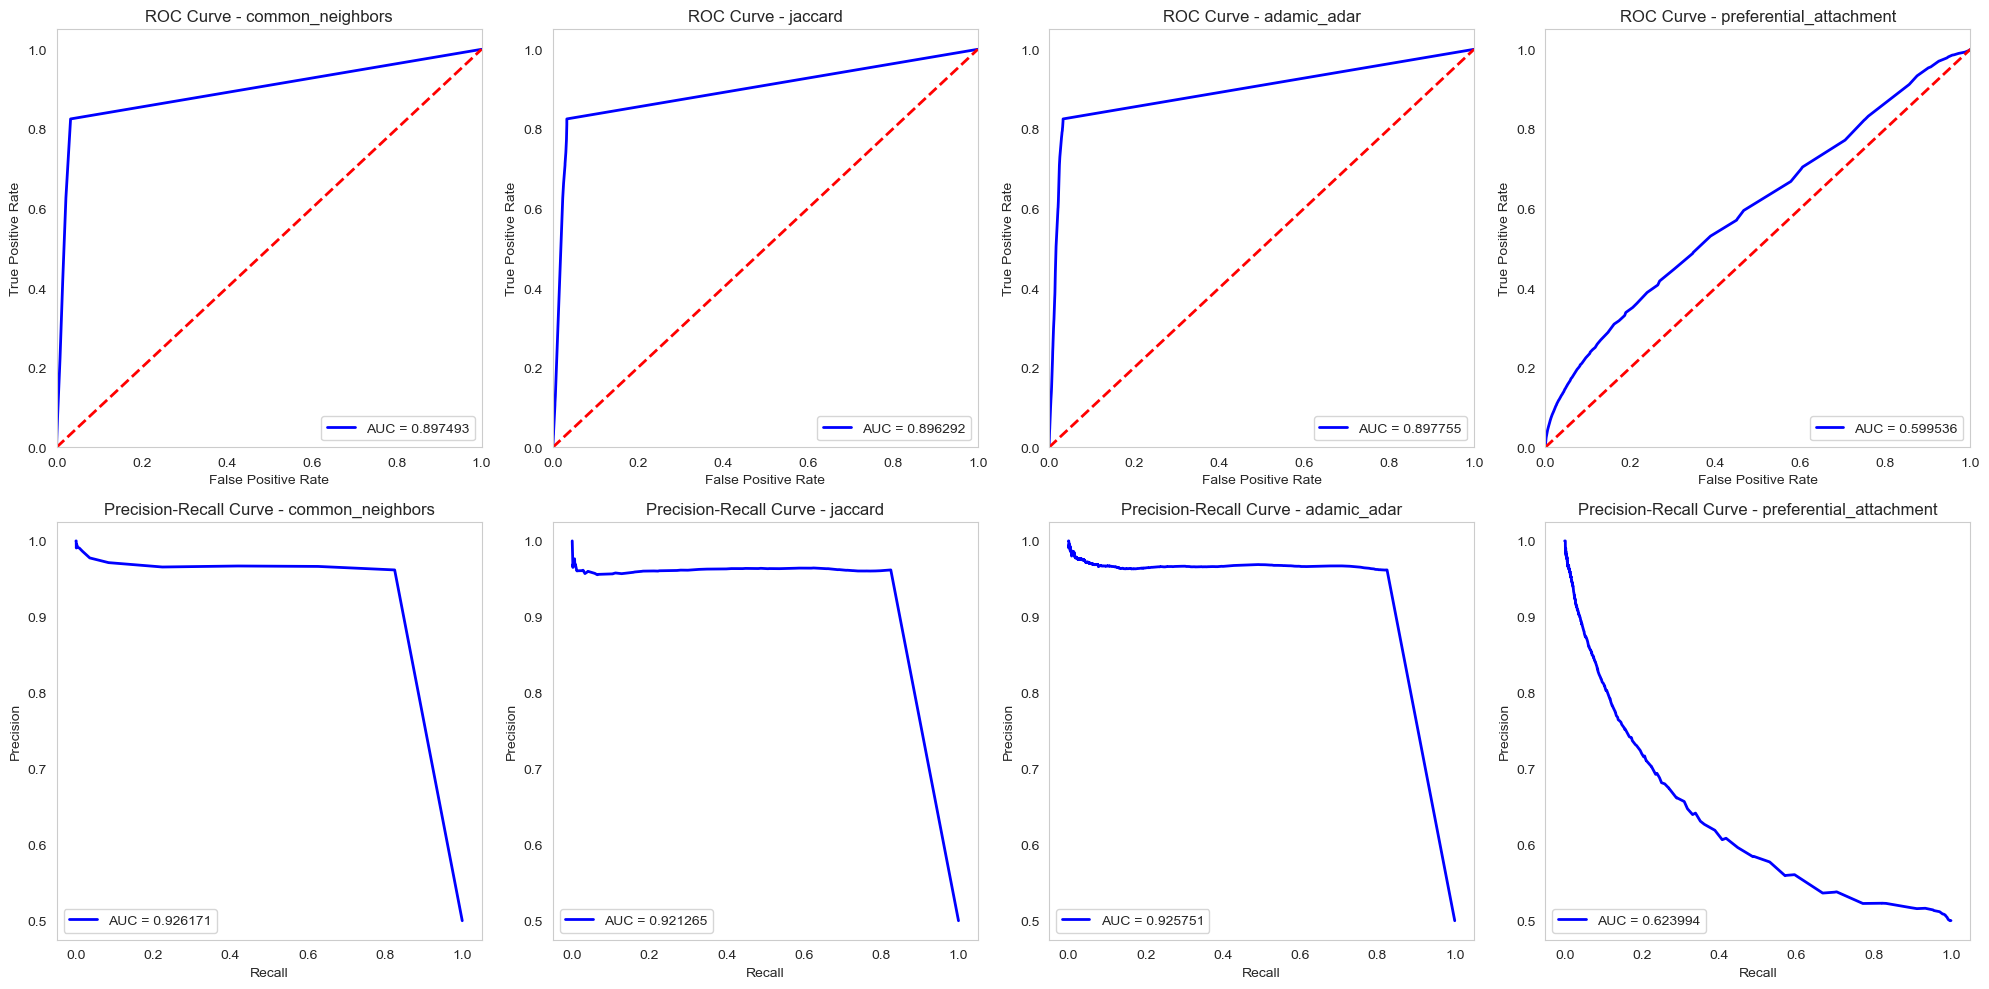

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fig, axes = plt.subplots(2, len(methods), figsize=(20, 10))

for i, method in enumerate(methods):
    scores = np.array(heuristic_score(G_train, test_pairs, method))

    if method == "common_neighbors":
        min_score = np.min(scores)
        max_score = np.max(scores)
        scores = (scores - min_score) / (max_score - min_score)

    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.6f}')
    axes[0, i].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - {method}')
    axes[0, i].legend(loc='lower right')
    axes[0, i].grid()

    precision, recall, _ = precision_recall_curve(labels, scores)
    pr_auc = auc(recall, precision)
    
    axes[1, i].plot(recall, precision, color='blue', lw=2, label=f'AUC = {pr_auc:.6f}')
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'Precision-Recall Curve - {method}')
    axes[1, i].legend(loc='lower left')
    axes[1, i].grid()

plt.tight_layout()
plt.show()


Dari hasil grafik, terlihat bahwa metode Common Neighbors, Jaccard, dan Adamic-Adar memiliki performa yang cukup baik dalam memprediksi keberadaan edge dalam graf. Ketiga metode ini menunjukkan nilai AUC ROC di kisaran 0.89-0.90, yang berarti model bisa membedakan dengan baik antara pasangan node yang terhubung dan yang tidak. Kita melihat bahwa kurva langsung meningkat tajam di awal (FPR = 0.0 hingga 0.1), menunjukkan bahwa model mampu menangkap banyak pasangan produk yang benar dengan sedikit kesalahan pada threshold tinggi. Ini berarti sistem rekomendasi dapat dengan cepat mengidentifikasi bundling produk yang sangat relevan. Namun, setelah titik sekitar 0.8, kenaikannya melandai, yang menandakan bahwa untuk meningkatkan recall lebih jauh, model harus mulai memasukkan lebih banyak pasangan yang kurang relevan. Namun, ROC curve Preferential Attachment lebih linear dengan AUC hanya sekitar 0.59. Ini karena metode ini hanya mempertimbangkan produk populer tanpa melihat keterkaitan langsung antar produk. Akibatnya, model kurang efektif membedakan pasangan produk yang benar-benar relevan, sehingga peningkatan True Positive Rate lebih lambat. Dalam rekomendasi bundling, metode ini lebih cocok untuk mempromosikan produk populer tetapi kurang akurat dalam menyusun kombinasi produk yang relevan bagi pelanggan.

Sedangkan, dari grafik PR Curve, tiga metode pertama (common_neighbors, jaccard, adamic_adar) memiliki pola yang hampir identik dengan precision tinggi yang stabil sebelum akhirnya turun drastis pada recall sekitar 0.85. Hal ini menunjukkan bahwa model dapat memberikan rekomendasi dengan presisi tinggi pada sebagian besar pasangan sebelum mengalami degradasi ketika semakin banyak pasangan diprediksi. Sementara itu, metode preferential_attachment memiliki tren yang sangat berbeda, dengan precision yang terus menurun seiring meningkatnya recall. Ini menunjukkan bahwa metode ini kurang mampu mempertahankan presisi saat mencoba mencakup lebih banyak pasangan, yang berarti banyak rekomendasi yang dihasilkan cenderung kurang relevan.

## Basic ML Link Prediction

### Feature Selection

In [26]:
def extract_features(G, edge_list):
    features = []

    for u, v in edge_list:
        common_neighbors = len(list(nx.common_neighbors(G, u, v)))
        jaccard = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        pref_attach = list(nx.preferential_attachment(G, [(u, v)]))[0][2]

        node_features = ['salesrank', 'review_cnt', 'downloads', 'rating', 
                         'in_degree', 'out_degree', 'pagerank_centrality', 
                         'betweenness_centrality', 'harmonic_closeness_centrality', 
                         'degree_centrality', 'community']

        node_u_features = [G.nodes[u].get(feat, 0) for feat in node_features]
        node_v_features = [G.nodes[v].get(feat, 0) for feat in node_features]

        features.append([u, v, common_neighbors, jaccard, pref_attach] + node_u_features + node_v_features)

    columns = ["node1", "node2", "common_neighbors", "jaccard", "preferential_attachment"] 
    columns += [f"{feat}_u" for feat in node_features]
    columns += [f"{feat}_v" for feat in node_features]

    return pd.DataFrame(features, columns=columns)

def feature_selection(X_train, y_train, top_k=10):
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

    feature_ranking = np.argsort(mi_scores)[::-1]

    selected_features = feature_ranking[:top_k]
    X_train_selected = X_train.iloc[:, selected_features]

    return X_train_selected, selected_features


In [27]:
train_pairs = train_edges + train_non_edges
train_labels = np.array([1] * len(train_edges) + [0] * len(train_non_edges))

test_pairs = test_edges + test_non_edges
test_labels = np.array([1] * len(test_edges) + [0] * len(test_non_edges))

train_features = extract_features(G_train, train_pairs)
test_features = extract_features(G_train, test_pairs)

X_train = train_features.drop(columns=["node1", "node2"])
X_test = test_features.drop(columns=["node1", "node2"])

# X_train_selected, selected_features = feature_selection(X_train, train_labels, top_k=10)
# selected_feature_names = X_train.columns[selected_features]
# print("Fitur yang dipilih:", selected_feature_names.tolist())

# X_test_selected = X_test.iloc[:, selected_features]


### Train and Evaluation

In [136]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB()
}

k = 1000

print("{:<25} {:>10} {:>10} {:>15} {:>10} {:>10}".format(
    "Method", "AUC-ROC", "AP Score", f"Precision@{k}", "PR AUC", f"NDCG@{k}"
))
print("=" * 140)

for name, model in models.items():
    model.fit(X_train, train_labels)
    
    probabilities = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(test_labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(test_labels, probabilities)
    pr_auc = auc(recall, precision)

    auc_roc = roc_auc_score(test_labels, probabilities)
    ap_score = average_precision_score(test_labels, probabilities)
    p_at_k = precision_at_k(test_labels, probabilities, k)
    ndcg_score_at_k = ndcg_score([test_labels], [probabilities], k=k)

    results.append((name, auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k))

    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        name.upper(), auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k
    ))


Method                       AUC-ROC   AP Score  Precision@1000     PR AUC  NDCG@1000
RANDOM FOREST               0.874455   0.908600        1.000000   0.909542   0.997630
LOGISTIC REGRESSION         0.898682   0.918170        0.996000   0.919254   0.995981
NAIVE BAYES                 0.913973   0.918488        1.000000   0.925263   0.963484


- Naive Bayes memiliki AUC-ROC tertinggi (0.913973), menunjukkan bahwa model ini paling baik dalam membedakan pasangan link yang valid dan tidak valid.

- Random Forest dan Naive Bayes memiliki Precision@1000 sempurna (1.0), berarti semua rekomendasi dalam top 1000 benar, menjadikannya pilihan kuat untuk sistem dengan batas rekomendasi ketat.

- Logistic Regression adalah yang terendah dalam Precision@1000 (0.9998)

- Random Forest memiliki skor NDCG@1000 tertinggi (0.997630), menandakan model ini mampu memberikan peringkat rekomendasi yang lebih relevan.

- Kesimpulan: Random Forest tetap menjadi pilihan terbaik untuk akurasi peringkat dan precision tinggi, sedangkan Naive Bayes unggul dalam separability (AUC-ROC) dan trade-off antara precision dan recall (PR AUC).

## Graph Neural Network (GNN) Link Prediction

In [114]:
!pip install torch-geometric


Setelah beberapa kali *tuning* dalam parameternya, model yang dibangun adalah sebagai berikut.

1. **Lapisan Input**
    - **Learnable Node Embeddings**: `torch.nn.Embedding(num_nodes, 32)`
        - Setiap node memiliki embedding berdimensi 32.

2. **Lapisan Konvolusi Graf** (GCN)
    - **GCNConv(32 → 64)** → Konvolusi Awal
        - Aktivasi ReLU
        - Dropout (p=0.5)

    - **GCNConv(64 → 64)** → Konvolusi Tambahan
        - Aktivasi ReLU
        - Dropout (p=0.5)

    - **GCNConv(64 → 32)** → Konvolusi Akhir

3. **Edge Decoder** (Link Prediction)

    - **Dot Product Decoder**

        - Menghitung $$score(u,v)=z_u * z_v$$
        - Menghasilkan skor probabilitas untuk setiap hubungan (edge). (logit score)

4. **Loss Function**

    - **Binary Cross Entropy dengan Logits** (`BCEWithLogitsLoss`).
    - **Regularisasi L2** (`torch.norm(z, p=2)`).

5. **Optimisasi**
    - **Optimizer**: AdamW
        - Learning rate: 0.002
        - Weight decay: 5e-4
    - **Learning Rate Scheduler**: `StepLR(step_size=15, gamma=0.7)`
        - Mengurangi learning rate setiap 15 epoch.

In [115]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}
edge_index = torch.tensor(
    [[node_to_idx[u], node_to_idx[v]] for u, v in G.edges() if u in node_to_idx and v in node_to_idx],
    dtype=torch.long
).t().contiguous()

# Use learnable node embeddings with higher dimension
num_nodes = G.number_of_nodes()
embedding_dim = 64
x = torch.nn.Embedding(num_nodes, embedding_dim).weight

data = Data(x=x, edge_index=edge_index)

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.3)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        return self.conv3(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

# Initialize model and optimizer
model = GNN(in_channels=embedding_dim, hidden_channels=64, out_channels=32)  # Increased hidden size
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-4)  # Adjusted learning rate & weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)  # More frequent LR decay

# Training loop
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()

    z = model.encode(data.x, data.edge_index)
    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index, num_nodes=data.num_nodes, num_neg_samples=2 * len(pos_edge_index[0])  # Increased negatives
    )

    pos_out = model.decode(z, pos_edge_index)
    neg_out = model.decode(z, neg_edge_index)

    out = torch.cat([pos_out, neg_out], dim=0)
    labels = torch.cat([torch.ones(pos_out.size(0)), torch.zeros(neg_out.size(0))], dim=0)

    loss = F.binary_cross_entropy_with_logits(out, labels)
    # loss += 0.001 * torch.norm(z, p=2)  # L2 regularization
    loss.backward()
    optimizer.step()
    scheduler.step()

    # if epoch % 10 == 0:
    #     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.2200
Epoch: 002, Loss: 0.7479
Epoch: 003, Loss: 0.6618
Epoch: 004, Loss: 0.6575
Epoch: 005, Loss: 0.6704
Epoch: 006, Loss: 0.6803
Epoch: 007, Loss: 0.6824
Epoch: 008, Loss: 0.6794
Epoch: 009, Loss: 0.6755
Epoch: 010, Loss: 0.6719
Epoch: 011, Loss: 0.6695
Epoch: 012, Loss: 0.6678
Epoch: 013, Loss: 0.6668
Epoch: 014, Loss: 0.6659
Epoch: 015, Loss: 0.6653
Epoch: 016, Loss: 0.6648
Epoch: 017, Loss: 0.6644
Epoch: 018, Loss: 0.6636
Epoch: 019, Loss: 0.6627
Epoch: 020, Loss: 0.6617
Epoch: 021, Loss: 0.6607
Epoch: 022, Loss: 0.6591
Epoch: 023, Loss: 0.6576
Epoch: 024, Loss: 0.6558
Epoch: 025, Loss: 0.6538
Epoch: 026, Loss: 0.6520
Epoch: 027, Loss: 0.6499
Epoch: 028, Loss: 0.6474
Epoch: 029, Loss: 0.6448
Epoch: 030, Loss: 0.6424
Epoch: 031, Loss: 0.6396
Epoch: 032, Loss: 0.6376
Epoch: 033, Loss: 0.6360
Epoch: 034, Loss: 0.6339
Epoch: 035, Loss: 0.6321
Epoch: 036, Loss: 0.6305
Epoch: 037, Loss: 0.6285
Epoch: 038, Loss: 0.6269
Epoch: 039, Loss: 0.6253
Epoch: 040, Loss: 0.6238


In [124]:
# load model weights
model = GNN(in_channels=embedding_dim, hidden_channels=64, out_channels=32)  # Same architecture
model.load_state_dict(torch.load("gnn_model.pth"))

<All keys matched successfully>

In [125]:
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.edge_index)
    
    test_edges_tensor = torch.tensor(
        [[node_to_idx[u], node_to_idx[v]] for u, v in test_edges if u in node_to_idx and v in node_to_idx],
        dtype=torch.long
    ).t().contiguous()
    test_non_edges_tensor = torch.tensor(
        [[node_to_idx[u], node_to_idx[v]] for u, v in test_non_edges if u in node_to_idx and v in node_to_idx],
        dtype=torch.long
    ).t().contiguous()

    test_pos_out = model.decode(z, test_edges_tensor)
    test_neg_out = model.decode(z, test_non_edges_tensor)

    out_test = torch.cat([test_pos_out, test_neg_out], dim=0)
    labels_test = torch.cat([torch.ones(test_pos_out.size(0)), torch.zeros(test_neg_out.size(0))], dim=0)

    k = 1000 

    probabilities = out_test.cpu().numpy()
    labels_np = labels_test.cpu().numpy()

    fpr, tpr, _ = roc_curve(labels_np, probabilities)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(labels_np, probabilities)
    pr_auc = auc(recall, precision)

    auc_roc = roc_auc_score(labels_np, probabilities)
    ap_score = average_precision_score(labels_np, probabilities)
    p_at_k = precision_at_k(labels_np, probabilities, k)
    ndcg_score_at_k = ndcg_score([labels_np], [probabilities], k=k)

    results.append(("GNN", auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k))

    print("{:<25} {:>10} {:>10} {:>15} {:>10} {:>10}".format(
        "Method", "AUC-ROC", "AP Score", f"Precision@{k}", "PR AUC", f"NDCG@{k}"
    ))
    print("=" * 140)
    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        "GNN", auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k
    ))


Method                       AUC-ROC   AP Score  Precision@1000     PR AUC  NDCG@1000
GNN                         0.892936   0.887992        0.984000   0.887991   0.984853


In [117]:
# Save the model
torch.save(model.state_dict(), "gnn_model.pth")
print("Success!")

Success!


## Perbandingan Semua Model Link Prediction

In [ ]:
print("{:<25} {:>10} {:>10} {:>15} {:>10} {:>10}".format(
        "Method", "AUC-ROC", "AP Score", f"Precision@{k}", "PR AUC", f"NDCG@{k}"
    ))
print("=" * 140)
for method, auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k in results:
    print("{:<25} {:>10.6f} {:>10.6f} {:>15.6f} {:>10.6f} {:>10.6f}".format(
        method.upper(), auc_roc, ap_score, p_at_k, pr_auc, ndcg_score_at_k
    ))

Method                       AUC-ROC   AP Score  Precision@1000     PR AUC  NDCG@1000
COMMON_NEIGHBORS            0.897493   0.884728        0.991000   0.926171   0.991311
JACCARD                     0.896292   0.880814        0.969000   0.921265   0.968421
ADAMIC_ADAR                 0.897755   0.885336        0.980000   0.925751   0.982933
PREFERENTIAL_ATTACHMENT     0.599536   0.620427        0.968000   0.623994   0.972045
RANDOM FOREST               0.874455   0.908600        1.000000   0.909542   0.997630
LOGISTIC REGRESSION         0.898682   0.918170        0.996000   0.919254   0.995981
NAIVE BAYES                 0.913973   0.918488        1.000000   0.925263   0.963484
GNN                         0.892936   0.887992        0.984000   0.887991   0.984853


- Naïve Bayes dan Random Forest memiliki Precision@1000 = 1.0, menunjukkan prediksinya sangat akurat dalam top-1000 rekomendasi.
- Random Forest memiliki nilai NDCG@1000 tertinggi (0.997630), menunjukkan ranking prediksi yang sangat baik.
- Preferential Attachment memiliki performa terburuk (AUC-ROC = 0.599536), yang menunjukkan metode ini tidak efektif untuk dataset ini.
- GNN memiliki performa seimbang, tetapi tidak lebih unggul dibandingkan metode Machine Learning tradisional seperti Naïve Bayes dan Logistic Regression.

**Kesimpulan**:
- Machine Learning (Random Forest, Naïve Bayes, Logistic Regression) lebih unggul dibanding heuristik klasik dan GNN dalam skenario ini.
- Random Forest menjadi model terbaik secara keseluruhan, terutama dalam ranking prediksi (NDCG@1000).
- Heuristik seperti Common Neighbors dan Adamic-Adar tetap kompetitif dibanding model ML biasa atau  GNN.